In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load ---
path = "data_transportation_faculty.xlsx"
people = pd.read_excel(path, sheet_name="People")
rank = pd.read_excel(path, sheet_name="University Rankings")

# --- If First_Hire is missing, set it equal to Current_Institution ---
people["First_Hire"] = people["First_Hire"].fillna(people["Current_Institution"])

# --- Map schools to US News tiers ---
tier_map = dict(zip(rank["School"], rank["US_News_Tier"]))

people["PhD_Tier"] = people["PhD_Institution"].map(tier_map)
people["Hire_Tier"] = people["First_Hire"].map(tier_map)

# Keep only rows where we can define the transition (PhD + first hire present)
df = people.dropna(subset=["PhD_Institution", "First_Hire"]).copy()

# Treat schools not in the ranking list as a separate bucket
df["PhD_Tier"] = df["PhD_Tier"].fillna("Not ranked or non US")
df["Hire_Tier"] = df["Hire_Tier"].fillna("Not ranked or non US")

# Section 3 Results

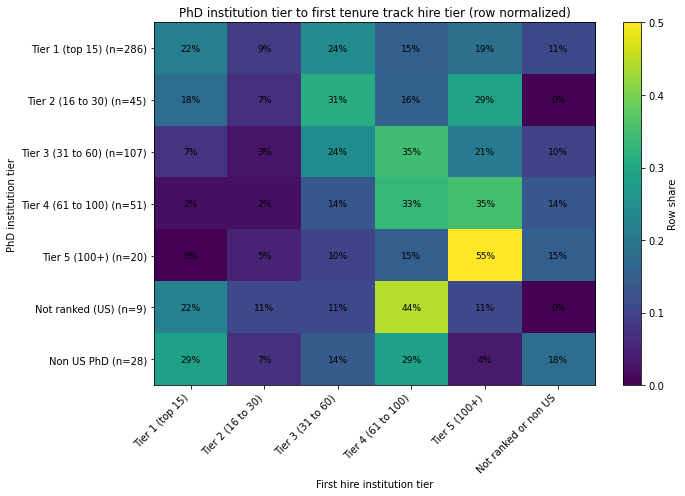

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# Split the PhD tier row only
# ----------------------------
df = df.copy()

# Start from the existing tier labels
df["PhD_Tier_split"] = df["PhD_Tier"]

# Define masks
mask_non_us_phd = df["PhD_Country"].notna() & ~df["PhD_Country"].isin(["United States", "USA", "US"])
mask_unranked_bucket = df["PhD_Tier"].astype(str).str.strip().eq("Not ranked or non US")

# Assign split labels
df.loc[mask_non_us_phd, "PhD_Tier_split"] = "Non US PhD"
df.loc[~mask_non_us_phd & mask_unranked_bucket, "PhD_Tier_split"] = "Not ranked (US)"

# ----------------------------
# Order tiers
# ----------------------------
tier_order_rows = [
    "Tier 1 (Top 15)",
    "Tier 2 (16–30)",
    "Tier 3 (31–60)",
    "Tier 4 (61–100)",
    "Tier 5 (100+)",
    "Not ranked (US)",
    "Non US PhD",
]

tier_order_cols = [
    "Tier 1 (Top 15)",
    "Tier 2 (16–30)",
    "Tier 3 (31–60)",
    "Tier 4 (61–100)",
    "Tier 5 (100+)",
    "Not ranked or non US",
]

# ----------------------------
# Transition matrix (row-normalized)
# ----------------------------
mat = pd.crosstab(
    df["PhD_Tier_split"],
    df["Hire_Tier"],
    normalize="index"
)
mat = mat.reindex(index=tier_order_rows, columns=tier_order_cols).fillna(0.0)

# ----------------------------
# Row sample sizes
# ----------------------------
row_counts = (
    df["PhD_Tier_split"]
    .value_counts()
    .reindex(tier_order_rows)
    .fillna(0)
    .astype(int)
)

# ----------------------------
# Display labels (no punctuation)
# ----------------------------
display = {
    "Tier 1 (Top 15)": "Tier 1 (top 15)",
    "Tier 2 (16–30)": "Tier 2 (16 to 30)",
    "Tier 3 (31–60)": "Tier 3 (31 to 60)",
    "Tier 4 (61–100)": "Tier 4 (61 to 100)",
    "Tier 5 (100+)": "Tier 5 (100+)",
    "Not ranked (US)": "Not ranked (US)",
    "Non US PhD": "Non US PhD",
    "Not ranked or non US": "Not ranked or non US",
}

xticklabels = [display.get(x, x) for x in mat.columns]
yticklabels = [
    f"{display.get(y, y)} (n={row_counts.loc[y]})"
    for y in mat.index
]

# ----------------------------
# Plot heatmap
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")
ax.set_facecolor("white")

im = ax.imshow(mat.values, vmin=0, vmax=0.5, aspect="auto")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Row share")

ax.set_xticks(np.arange(mat.shape[1]))
ax.set_yticks(np.arange(mat.shape[0]))
ax.set_xticklabels(xticklabels, rotation=45, ha="right")
ax.set_yticklabels(yticklabels)

ax.set_xlabel("First hire institution tier")
ax.set_ylabel("PhD institution tier")
ax.set_title("PhD institution tier to first tenure track hire tier (row normalized)")

# Annotate cells
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        val = mat.iat[i, j]
        ax.text(j, i, f"{val*100:.0f}%", ha="center", va="center", fontsize=9)

fig.tight_layout()
fig.savefig("fig_tier_transition_heatmap.png", dpi=300)
plt.show()


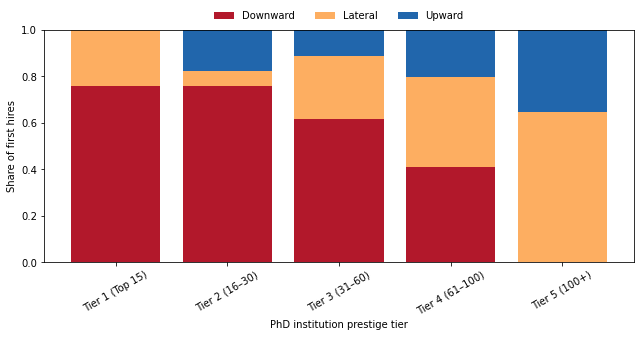

N used for mobility figure: 456
PhD tier counts used:
 Tier 1 (Top 15)    254
Tier 3 (31–60)      96
Tier 2 (16–30)      45
Tier 4 (61–100)     44
Tier 5 (100+)       17
Name: PhD_Tier, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Start from df that already has PhD_Tier and Hire_Tier (from your Figure 1 pipeline)
df2 = df.copy()

# Drop the non ordered category for mobility (mobility is not well-defined there)
df2 = df2[df2["PhD_Tier"] != "Not ranked or non US"].copy()

# Use ONLY ranked tiers in the order (highest prestige first)
tier_order_ranked = [
    "Tier 1 (Top 15)",
    "Tier 2 (16–30)",
    "Tier 3 (31–60)",
    "Tier 4 (61–100)",
    "Tier 5 (100+)",
]


df2["PhD_Tier"] = df2["PhD_Tier"]
df2["Hire_Tier"] = df2["Hire_Tier"]

# Rank tiers numerically so we can compute up / lateral / down
tier_rank = {t: i for i, t in enumerate(tier_order_ranked, start=1)}
df2["phd_r"] = df2["PhD_Tier"].map(tier_rank)
df2["hire_r"] = df2["Hire_Tier"].map(tier_rank)

# Keep only rows where both tiers are ranked (this also drops hires that are not ranked or non US)
df2 = df2.dropna(subset=["phd_r", "hire_r"]).copy()

# Define mobility category
df2["mobility"] = np.where(
    df2["hire_r"] < df2["phd_r"], "Upward",
    np.where(df2["hire_r"] == df2["phd_r"], "Lateral", "Downward")
)

# Row-normalized stacked distribution by PhD tier
by = (
    pd.crosstab(df2["PhD_Tier"], df2["mobility"], normalize="index")
    .reindex(index=tier_order_ranked, columns=["Downward", "Lateral", "Upward"])
    .fillna(0)
)

# Colors (muted, print-safe)
colors = {
    "Downward": "#b2182b",
    "Lateral":  "#fdae61",
    "Upward":   "#2166ac",
}

fig, ax = plt.subplots(figsize=(9, 4.8), facecolor="white")
ax.set_facecolor("white")

bottom = np.zeros(len(by))
for col in ["Downward", "Lateral", "Upward"]:
    ax.bar(
        by.index,
        by[col].values,
        bottom=bottom,
        label=col,
        color=colors[col]
    )
    bottom += by[col].values

ax.set_ylim(0, 1)
ax.set_ylabel("Share of first hires")
ax.set_xlabel("PhD institution prestige tier")
ax.tick_params(axis="x", rotation=30)

# Legend above plot, with space
ax.legend(
    ncol=3,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.12),
    frameon=False
)
fig.subplots_adjust(top=0.82)

fig.tight_layout()
fig.savefig("fig_mobility_by_phd_tier.png", dpi=300)
plt.show()

# Optional sanity prints
print("N used for mobility figure:", len(df2))
print("PhD tier counts used:\n", df2["PhD_Tier"].value_counts())


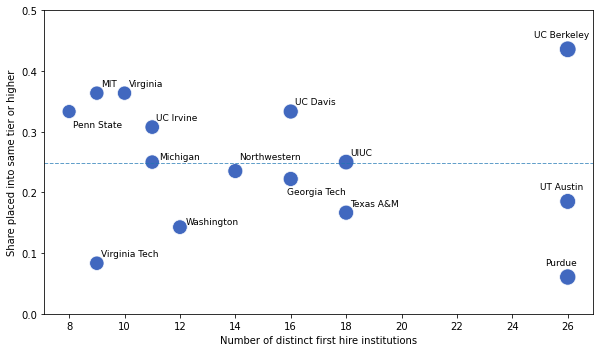

                            PhD_Institution  n_placements  n_destinations  \
40       University of California, Berkeley            39              26   
27                        Purdue University            33              26   
66            University of Texas at Austin            27              26   
50  University of Illinois Urbana-Champaign            24              18   
10          Georgia Institute of Technology            18              16   
31                     Texas A&M University            18              18   
41          University of California, Davis            18              16   
22                  Northwestern University            17              14   
68                 University of Washington            14              12   
36                                UC Irvine            13              11   
55                   University of Michigan            12              11   
72                            Virginia Tech            12               9   

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Start from df2 (ranked-only data already used for Figure 2)
df3 = df2.copy()

# Tier order and numeric rank (lower = higher prestige)
tier_order = [
    "Tier 1 (Top 15)",
    "Tier 2 (16–30)",
    "Tier 3 (31–60)",
    "Tier 4 (61–100)",
    "Tier 5 (100+)",
]

tier_rank = {t: i for i, t in enumerate(tier_order, start=1)}

df3["phd_r"] = df3["PhD_Tier"].map(tier_rank)
df3["hire_r"] = df3["Hire_Tier"].map(tier_rank)

# Keep rows where both sides are ranked
df3 = df3.dropna(
    subset=["phd_r", "hire_r", "PhD_Institution", "First_Hire"]
).copy()

# Same-tier-or-higher placement indicator
df3["same_or_higher"] = (df3["hire_r"] <= df3["phd_r"]).astype(int)

# Aggregate placement statistics by PhD institution
stats = (
    df3.groupby("PhD_Institution")
    .agg(
        n_placements=("First_Hire", "size"),
        n_destinations=("First_Hire", pd.Series.nunique),
        share_same_or_higher=("same_or_higher", "mean"),
    )
    .reset_index()
)

# Select top 10 PhD institutions by placement volume
top10 = (
    stats.sort_values("n_placements", ascending=False)
    .head(15)
    .copy()
)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(8.5, 5), facecolor="white")
ax.set_facecolor("white")

# Point sizes scale with placement volume
sizes = 120 + 25 * np.sqrt(top10["n_placements"])

ax.scatter(
    top10["n_destinations"],
    top10["share_same_or_higher"],
    s=sizes,
    color="#1f4eb4",      # muted slate blue
    alpha=0.85,
    edgecolor="white",
    linewidth=0.8
)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel("Number of distinct first hire institutions")
ax.set_ylabel("Share placed into same tier or higher")
ax.set_ylim(0, 0.5)

# Reference line at mean (top 10 only)
mean_val = top10["share_same_or_higher"].mean()
ax.axhline(mean_val, linestyle="--", linewidth=1, alpha=0.7)

short_names = {
    "University of Illinois Urbana-Champaign": "UIUC",
    "Georgia Institute of Technology": "Georgia Tech",
    "Northwestern University": "Northwestern",
    "University of Michigan": "Michigan",
    "Massachusetts Institute of Technology": 'MIT',
    'University of Texas at Austin': 'UT Austin',
    'Purdue University': 'Purdue',
    'Texas A&M University': 'Texas A&M',
    'University of California, Berkeley': 'UC Berkeley',
    'University of California, Davis': 'UC Davis',
    'University of Washington': 'Washington',
    'University of Virginia': 'Virginia',
    'Penn State University': 'Penn State'
}

label_offsets = {
    "Northwestern University": (0.15, 0.02),
    "Georgia Institute of Technology": (-0.15, -0.025),
    # "University of Illinois Urbana-Champaign": (0.25, 0.015),
    "University of Michigan": (0.25, 0.005),
    "Texas A&M University": (0.15, 0.01),
    "University of Washington": (0.2, 0.005),
    "University of Texas at Austin": (-1, 0.02),
    "Purdue University": (-0.8, 0.02),
    "University of California, Berkeley": (-1.2, 0.02),
    'Penn State University': (0.15, -0.025)
}

# Label all points (only 10, so this is clean)
for _, r in top10.iterrows():
    label = short_names.get(r["PhD_Institution"], r["PhD_Institution"])
    dx, dy = label_offsets.get(r["PhD_Institution"], (0.15, 0.012))
    ax.text(
        r["n_destinations"] + dx,
        r["share_same_or_higher"] + dy,
        label,
        fontsize=9
    )

fig.tight_layout()
fig.savefig("fig_placement_concentration_top15.png", dpi=300)
plt.show()

# Optional sanity output
print(top10.sort_values("n_placements", ascending=False))


# Section 4 Results

In [13]:
import numpy as np
import pandas as pd

# Use the same tier strings your df already has
tier_order_ranked = [
    "Tier 1 (Top 15)",
    "Tier 2 (16–30)",
    "Tier 3 (31–60)",
    "Tier 4 (61–100)",
    "Tier 5 (100+)",
]

tier_to_int = {t: i + 1 for i, t in enumerate(tier_order_ranked)}  # 1 best, 5 worst

# Ranked only sample for ordered model
dfm = df[df["PhD_Tier"].isin(tier_order_ranked) & df["Hire_Tier"].isin(tier_order_ranked)].copy()

dfm["y_hire"] = dfm["Hire_Tier"].map(tier_to_int).astype(int)
dfm["PhD_Tier"] = pd.Categorical(dfm["PhD_Tier"], categories=tier_order_ranked, ordered=True)

In [14]:
# Cohort bins from PhD_Year (customize bins if you want)
def add_cohort_bins(d, year_col="PhD_Year", bins=(1970, 1985, 1995, 2005, 2015, 2026)):
    d = d.copy()
    y = pd.to_numeric(d[year_col], errors="coerce")
    d["PhD_Year_num"] = y
    labels = [f"{bins[i]} to {bins[i+1]-1}" for i in range(len(bins)-1)]
    d["phd_cohort"] = pd.cut(y, bins=bins, labels=labels, right=False, include_lowest=True)
    d["phd_cohort"] = d["phd_cohort"].astype(object).fillna("Unknown")
    return d

dfm = add_cohort_bins(dfm, year_col="PhD_Year")
dfm["phd_cohort"].value_counts(dropna=False).head(10)

2015 to 2025    132
2005 to 2014    123
1995 to 2004     99
1985 to 1994     55
Unknown          24
1970 to 1984     23
Name: phd_cohort, dtype: int64

In [15]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.sandwich_covariance import cov_cluster

def make_us_vs_nonus(series: pd.Series) -> pd.Series:
    s = series.astype(object).fillna("Unknown")
    is_us = s.str.contains(r"\bunited states\b|\busa\b|\bu\.s\.\b|\bus\b", case=False, na=False)
    return pd.Series(np.where(is_us, "US", "Non US"), index=series.index)

def design_matrix(d, include_cohort=False, include_background=False):
    parts = []

    # PhD tier indicators (reference category = Tier 1)
    parts.append(pd.get_dummies(d["PhD_Tier"], prefix="phd_tier", drop_first=True))

    if include_cohort:
        parts.append(pd.get_dummies(d["phd_cohort"], prefix="cohort", drop_first=True))

    if include_background:
        # Keep these coarse to avoid sparse categories
        parts.append(pd.get_dummies(make_us_vs_nonus(d["UG_Country"]), prefix="ug", drop_first=True))
        parts.append(pd.get_dummies(make_us_vs_nonus(d["PhD_Country"]), prefix="phd_country", drop_first=True))

        # Optional postdoc indicator (public records can be noisy)
        d = d.copy()
        d["has_postdoc"] = d["Postdoc_Institution"].notna().astype(int)
        parts.append(d[["has_postdoc"]])

    X = pd.concat(parts, axis=1).astype(float)
    return X

def fit_ordered_logit(d, include_cohort=False, include_background=False, cluster_col="PhD_Institution"):
    X = design_matrix(d, include_cohort, include_background)
    y = d["y_hire"]

    model = OrderedModel(y, X, distr="logit")
    res = model.fit(method="bfgs", disp=False)

    # Cluster-robust covariance (works even when get_robustcov_results is missing)
    groups = d[cluster_col]
    V_cl = cov_cluster(res, groups)  # covariance matrix (same parameter order as res.params)

    # Clustered SE
    se_cl = np.sqrt(np.diag(V_cl))
    se_cl = pd.Series(se_cl, index=res.params.index)

    # p-values using normal approx (fine for large-ish samples)
    z = res.params / se_cl
    p = 2 * (1 - __import__("scipy").stats.norm.cdf(np.abs(z)))

    # Pack a simple results table you can use in paper
    results_table = pd.DataFrame({
        "coef": res.params,
        "se_cluster": se_cl,
        "z": z,
        "p": p
    })

    return res, results_table, X


In [16]:
res1, tab1, X1 = fit_ordered_logit(dfm, include_cohort=False, include_background=False)
res2, tab2, X2 = fit_ordered_logit(dfm, include_cohort=True, include_background=False)
res3, tab3, X3 = fit_ordered_logit(dfm, include_cohort=True, include_background=True)

In [17]:
def keep_phd_tier_rows(tab):
    return tab.loc[[i for i in tab.index if str(i).startswith("phd_tier")]].copy()

coef_compare = (
    keep_phd_tier_rows(tab1).rename(columns={"coef":"M1_coef","se_cluster":"M1_se","p":"M1_p"})[["M1_coef","M1_se","M1_p"]]
    .join(keep_phd_tier_rows(tab2).rename(columns={"coef":"M2_coef","se_cluster":"M2_se","p":"M2_p"})[["M2_coef","M2_se","M2_p"]], how="outer")
    .join(keep_phd_tier_rows(tab3).rename(columns={"coef":"M3_coef","se_cluster":"M3_se","p":"M3_p"})[["M3_coef","M3_se","M3_p"]], how="outer")
)
coef_compare


,M1_coef,M1_se,M1_p,M2_coef,M2_se,M2_p,M3_coef,M3_se,M3_p
phd_tier_Tier 2 (16–30),0.413766,0.387222,0.285273,0.429527,0.417011,0.303004,0.435072,0.404476,0.282086
phd_tier_Tier 3 (31–60),0.785946,0.299359,0.008654,0.834218,0.309388,0.007010,0.811773,0.304512,0.007680
phd_tier_Tier 4 (61–100),1.471302,0.362652,0.000050,1.531957,0.350655,0.000012,1.391481,0.342261,0.000048
phd_tier_Tier 5 (100+),2.172982,0.464646,0.000003,2.154842,0.500100,0.000016,2.037544,0.514497,0.000075
